<a href="https://colab.research.google.com/github/ArunK-ML/Project---TripFare-Predicting-Urban-Taxi-Fare-with-Machine-Learning/blob/main/TripFare_ML_mind-overload.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚗 **TripFare : Predicting Urban Taxi Fare with Machine Learning**

In [144]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Collection

df = pd.read_csv("/content/drive/MyDrive/DataSet_For DS/taxi_fare.csv")
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,-73.976746,40.765152,1,N,-74.004265,40.746128,1,9.0,0.5,0.5,2.05,0.00,0.3,12.35
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,-73.983482,40.767925,1,N,-74.005943,40.733166,1,11.0,0.5,0.5,3.05,0.00,0.3,15.35
2,2,2016-03-01 00:00:00,2016-03-01 00:31:06,2,-73.782021,40.644810,1,N,-73.974541,40.675770,1,54.5,0.5,0.5,8.00,0.00,0.3,63.80
3,2,2016-03-01 00:00:00,2016-03-01 00:00:00,3,-73.863419,40.769814,1,N,-73.969650,40.757767,1,31.5,0.0,0.5,3.78,5.54,0.3,41.62
4,2,2016-03-01 00:00:00,2016-03-01 00:00:00,5,-73.971741,40.792183,3,N,-74.177170,40.695053,1,98.0,0.0,0.0,0.00,15.50,0.3,113.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212340,2,2016-03-01 12:15:37,2016-03-01 12:38:53,1,-73.955688,40.782261,1,N,-73.974915,40.751282,1,16.0,0.0,0.5,3.36,0.00,0.3,20.16
212341,2,2016-03-01 12:15:37,2016-03-01 12:38:22,1,-74.002197,40.715042,1,N,-73.976295,40.739609,1,15.5,0.0,0.5,2.00,0.00,0.3,18.30
212342,2,2016-03-01 12:15:37,2016-03-01 12:18:18,1,-73.991173,40.733170,1,N,-73.994324,40.728531,1,4.0,0.0,0.5,0.00,0.00,0.3,4.80
212343,1,2016-03-01 12:15:38,2016-03-01 12:22:47,2,-73.972099,40.786446,1,N,-73.955872,40.779755,2,7.0,0.0,0.5,0.00,0.00,0.3,7.80


In [146]:
df.shape

(212345, 18)

In [147]:
# --------------------------
# 2. Structure & Schema
# --------------------------
print("\n--- Data Types ---")
print(df.dtypes)

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Duplicate Rows ---")
print(df.duplicated().sum())


--- Data Types ---
VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID                 int64
store_and_fwd_flag        object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

--- Missing Values ---
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
pickup_longitude         0
pickup_latitude          0
RatecodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                   

In [148]:
# Change dtype

df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

In [149]:
# Haversine formula function
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Apply to your DataFrame
df["trip_distance_km"] = haversine_distance(
    df["pickup_latitude"],
    df["pickup_longitude"],
    df["dropoff_latitude"],
    df["dropoff_longitude"]
)


In [150]:
import pytz

df["pickup_year"] = df["tpep_pickup_datetime"].dt.year
df["pickup_month"] = df["tpep_pickup_datetime"].dt.month
df["pickup_day"] = df["tpep_pickup_datetime"].dt.day

# Ensure pickup_hour is extracted
df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
df["pickup_minute"] = df["tpep_pickup_datetime"].dt.minute
df["pickup_weekday"] = df["tpep_pickup_datetime"].dt.weekday

# Extract AM/PM
df['pickup_am_pm'] = df['tpep_pickup_datetime'].dt.strftime('%p')

# Binary flag for night trips (Yes if 10 PM to 5 AM)
df['pickup_is_night'] = df['pickup_hour'].apply(
    lambda x: "Yes" if (x >= 22 or x <= 5) else "No"
)

df["dropoff_year"] = df["tpep_dropoff_datetime"].dt.year
df["dropoff_month"] = df["tpep_dropoff_datetime"].dt.month
df["dropoff_day"] = df["tpep_dropoff_datetime"].dt.day

# Ensure dropoff is extracted
df["dropoff_hour"] = df["tpep_dropoff_datetime"].dt.hour
df["dropoff_minute"] = df["tpep_dropoff_datetime"].dt.minute
df["dropoff_weekday"] = df["tpep_dropoff_datetime"].dt.weekday

# Extract AM/PM
df['dropoff_am_pm'] = df['tpep_dropoff_datetime'].dt.strftime('%p')

# Binary flag for night trips (Yes if 10 PM to 5 AM)
df['dropoff_is_night'] = df['dropoff_hour'].apply(
    lambda x: "Yes" if (x >= 22 or x <= 5) else "No"
)

In [151]:
# Get numeric column names
numeric_cols = df.select_dtypes(include=['number']).columns

#  Convert all numeric values to positive
df[numeric_cols] = df[numeric_cols].abs()

In [152]:
# Get the time difference
# Difference in hours & minutes
df["hour_difference"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() // 3600
df["minute_difference"] = ((df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() % 3600) // 60

In [153]:
# Drop the columns
#df = df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

#df = df.drop(columns=["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"])

In [154]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,...,dropoff_year,dropoff_month,dropoff_day,dropoff_hour,dropoff_minute,dropoff_weekday,dropoff_am_pm,dropoff_is_night,hour_difference,minute_difference
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,73.976746,40.765152,1,N,74.004265,40.746128,...,2016,3,1,0,7,1,AM,Yes,0.0,7.0
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,73.983482,40.767925,1,N,74.005943,40.733166,...,2016,3,1,0,11,1,AM,Yes,0.0,11.0
2,2,2016-03-01 00:00:00,2016-03-01 00:31:06,2,73.782021,40.644810,1,N,73.974541,40.675770,...,2016,3,1,0,31,1,AM,Yes,0.0,31.0
3,2,2016-03-01 00:00:00,2016-03-01 00:00:00,3,73.863419,40.769814,1,N,73.969650,40.757767,...,2016,3,1,0,0,1,AM,Yes,0.0,0.0
4,2,2016-03-01 00:00:00,2016-03-01 00:00:00,5,73.971741,40.792183,3,N,74.177170,40.695053,...,2016,3,1,0,0,1,AM,Yes,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212340,2,2016-03-01 12:15:37,2016-03-01 12:38:53,1,73.955688,40.782261,1,N,73.974915,40.751282,...,2016,3,1,12,38,1,PM,No,0.0,23.0
212341,2,2016-03-01 12:15:37,2016-03-01 12:38:22,1,74.002197,40.715042,1,N,73.976295,40.739609,...,2016,3,1,12,38,1,PM,No,0.0,22.0
212342,2,2016-03-01 12:15:37,2016-03-01 12:18:18,1,73.991173,40.733170,1,N,73.994324,40.728531,...,2016,3,1,12,18,1,PM,No,0.0,2.0
212343,1,2016-03-01 12:15:38,2016-03-01 12:22:47,2,73.972099,40.786446,1,N,73.955872,40.779755,...,2016,3,1,12,22,1,PM,No,0.0,7.0


In [155]:
# Count zeros and negative values in each column

# Select only numeric columns
numeric_df = df.select_dtypes(include=np.number)

# Count zeros in each column
zero_count = (numeric_df == 0).sum()

# Count negative values in each column
negative_count = (numeric_df < 0).sum()

# Combine results
result = pd.DataFrame({
    'Zero_Count': zero_count,
    'Negative_Count': negative_count
})

print(result)

                       Zero_Count  Negative_Count
VendorID                        0               0
passenger_count                 9               0
pickup_longitude             2471               0
pickup_latitude              2471               0
RatecodeID                      0               0
dropoff_longitude            2383               0
dropoff_latitude             2383               0
payment_type                    0               0
fare_amount                    50               0
extra                      191930               0
mta_tax                       791               0
tip_amount                  73542               0
tolls_amount               200726               0
improvement_surcharge          45               0
total_amount                   38               0
trip_distance_km             2982               0
pickup_year                     0               0
pickup_month                    0               0
pickup_day                      0               0


In [156]:
df.to_csv("taxi_fare_cleaned_ff.csv")

In [157]:
# Drop rows where passenger_count == 0
df = df[df['passenger_count'] != 0]

# Drop rows where improvement_surcharge == 0
df = df[df['improvement_surcharge'] != 0]

# Drop rows where total_amount == 0
df = df[df['total_amount'] != 0]

In [158]:
# Get numeric column names
numeric_cols = df.select_dtypes(include=['number']).columns

#  Convert all numeric values to positive
df[numeric_cols] = df[numeric_cols].abs()

In [159]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=np.number)

# Count zeros in each column
zero_count = (numeric_df == 0).sum()

# Count negative values in each column
negative_count = (numeric_df < 0).sum()

# Combine results
result = pd.DataFrame({
    'Zero_Count': zero_count,
    'Negative_Count': negative_count
})

print(result)

                       Zero_Count  Negative_Count
VendorID                        0               0
passenger_count                 0               0
pickup_longitude             2457               0
pickup_latitude              2457               0
RatecodeID                      0               0
dropoff_longitude            2370               0
dropoff_latitude             2370               0
payment_type                    0               0
fare_amount                    11               0
extra                      191876               0
mta_tax                       748               0
tip_amount                  73493               0
tolls_amount               200672               0
improvement_surcharge           0               0
total_amount                    0               0
trip_distance_km             2973               0
pickup_year                     0               0
pickup_month                    0               0
pickup_day                      0               0


# **Null value Handling**

In [160]:
df["improvement_surcharge"].unique()

array([0.3])

In [161]:
df["mta_tax"].unique()

array([0.5, 0. ])

In [162]:
col1 = 'tip_amount'
mean_val = df[col1].mean()
df.loc[df[col1] == 0, col1] = mean_val

col2 = "trip_distance_km"
mean_val = df[col2].mean()
df.loc[df[col2] == 0, col2] = mean_val

col3 = "fare_amount"
mean_val = df[col3].mean()
df.loc[df[col3] == 0, col3] = mean_val


In [163]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=np.number)

# Count zeros in each column
zero_count = (numeric_df == 0).sum()

# Count negative values in each column
negative_count = (numeric_df < 0).sum()

# Combine results
result = pd.DataFrame({
    'Zero_Count': zero_count,
    'Negative_Count': negative_count
})

print(result)

                       Zero_Count  Negative_Count
VendorID                        0               0
passenger_count                 0               0
pickup_longitude             2457               0
pickup_latitude              2457               0
RatecodeID                      0               0
dropoff_longitude            2370               0
dropoff_latitude             2370               0
payment_type                    0               0
fare_amount                     0               0
extra                      191876               0
mta_tax                       748               0
tip_amount                      0               0
tolls_amount               200672               0
improvement_surcharge           0               0
total_amount                    0               0
trip_distance_km                0               0
pickup_year                     0               0
pickup_month                    0               0
pickup_day                      0               0


In [164]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'trip_distance_km', 'pickup_year', 'pickup_month', 'pickup_day',
       'pickup_hour', 'pickup_minute', 'pickup_weekday', 'pickup_am_pm',
       'pickup_is_night', 'dropoff_year', 'dropoff_month', 'dropoff_day',
       'dropoff_hour', 'dropoff_minute', 'dropoff_weekday', 'dropoff_am_pm',
       'dropoff_is_night', 'hour_difference', 'minute_difference'],
      dtype='object')

In [166]:
df = df[(df['pickup_longitude'] != 0) & (df['pickup_latitude'] != 0) &
        (df['dropoff_longitude'] != 0) & (df['dropoff_latitude'] != 0)]

In [168]:
df.shape

(209613, 37)

In [169]:
from sklearn.preprocessing import LabelEncoder
code = LabelEncoder()

for i in df.select_dtypes(include="object").columns:
  df[i] = code.fit_transform(df[i])

/tmp/ipython-input-3984021156.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = code.fit_transform(df[i])
/tmp/ipython-input-3984021156.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = code.fit_transform(df[i])
/tmp/ipython-input-3984021156.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [170]:
df


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,...,dropoff_year,dropoff_month,dropoff_day,dropoff_hour,dropoff_minute,dropoff_weekday,dropoff_am_pm,dropoff_is_night,hour_difference,minute_difference
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,73.976746,40.765152,1,0,74.004265,40.746128,...,2016,3,1,0,7,1,0,1,0.0,7.0
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,73.983482,40.767925,1,0,74.005943,40.733166,...,2016,3,1,0,11,1,0,1,0.0,11.0
2,2,2016-03-01 00:00:00,2016-03-01 00:31:06,2,73.782021,40.644810,1,0,73.974541,40.675770,...,2016,3,1,0,31,1,0,1,0.0,31.0
3,2,2016-03-01 00:00:00,2016-03-01 00:00:00,3,73.863419,40.769814,1,0,73.969650,40.757767,...,2016,3,1,0,0,1,0,1,0.0,0.0
4,2,2016-03-01 00:00:00,2016-03-01 00:00:00,5,73.971741,40.792183,3,0,74.177170,40.695053,...,2016,3,1,0,0,1,0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212340,2,2016-03-01 12:15:37,2016-03-01 12:38:53,1,73.955688,40.782261,1,0,73.974915,40.751282,...,2016,3,1,12,38,1,1,0,0.0,23.0
212341,2,2016-03-01 12:15:37,2016-03-01 12:38:22,1,74.002197,40.715042,1,0,73.976295,40.739609,...,2016,3,1,12,38,1,1,0,0.0,22.0
212342,2,2016-03-01 12:15:37,2016-03-01 12:18:18,1,73.991173,40.733170,1,0,73.994324,40.728531,...,2016,3,1,12,18,1,1,0,0.0,2.0
212343,1,2016-03-01 12:15:38,2016-03-01 12:22:47,2,73.972099,40.786446,1,0,73.955872,40.779755,...,2016,3,1,12,22,1,1,0,0.0,7.0


In [171]:
# --------------------------
# 3. Distribution & Skewness
# --------------------------

# Step 1: Select numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns

# Step 2: Loop through numeric columns
for col in numeric_cols:
    skew_val = df[col].skew()
    kurt_val = df[col].kurtosis()

    print(f"\nColumn: {col}")
    print(f"  Skewness: {skew_val:.3f}")
    print(f"  Kurtosis: {kurt_val:.3f}")

    # Step 3: Apply normality check thresholds
    if skew_val < 0.5 and skew_val > -0.5 and kurt_val < 3 and kurt_val > -3:
        print("  ✅ Looks approximately normal")
    else:
        print("  ⚠ Not normal (may need transformation)")


Column: VendorID
  Skewness: -0.930
  Kurtosis: -1.135
  ⚠ Not normal (may need transformation)

Column: passenger_count
  Skewness: 1.882
  Kurtosis: 2.126
  ⚠ Not normal (may need transformation)

Column: pickup_longitude
  Skewness: 13.969
  Kurtosis: 54751.657
  ⚠ Not normal (may need transformation)

Column: pickup_latitude
  Skewness: -11.506
  Kurtosis: 2223.216
  ⚠ Not normal (may need transformation)

Column: RatecodeID
  Skewness: 145.481
  Kurtosis: 43634.999
  ⚠ Not normal (may need transformation)

Column: store_and_fwd_flag
  Skewness: 18.158
  Kurtosis: 327.730
  ⚠ Not normal (may need transformation)

Column: dropoff_longitude
  Skewness: 247.700
  Kurtosis: 64102.770
  ⚠ Not normal (may need transformation)

Column: dropoff_latitude
  Skewness: -9.595
  Kurtosis: 1754.144
  ⚠ Not normal (may need transformation)

Column: payment_type
  Skewness: 0.923
  Kurtosis: -0.449
  ⚠ Not normal (may need transformation)

Column: fare_amount
  Skewness: 5.909
  Kurtosis: 203.466

In [172]:
# Transformation

# Methods (lambda values for Box-Cox)
methods = [0, 0.5, -0.5, -1, 1, 2, -2]

# Loop through numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    print(f"\n=== Column: {col} ===")

    # Box-Cox requires positive values
    if (df[col] <= 0).any():
        print("❌ Skipped (contains zero or negative values)")
        continue

    for j in methods:
        # Apply Box-Cox
        transformed = boxcox(df[col], lmbda=j)

        # Calculate skewness and kurtosis
        skew_val = pd.Series(transformed).skew()
        kurt_val = pd.Series(transformed).kurtosis()

        print(f"λ = {j}:  skew = {skew_val:.3f}, kurtosis = {kurt_val:.3f}")


=== Column: VendorID ===
λ = 0:  skew = -0.930, kurtosis = -1.135
λ = 0.5:  skew = -0.930, kurtosis = -1.135
λ = -0.5:  skew = -0.930, kurtosis = -1.135
λ = -1:  skew = -0.930, kurtosis = -1.135
λ = 1:  skew = -0.930, kurtosis = -1.135
λ = 2:  skew = -0.930, kurtosis = -1.135
λ = -2:  skew = -0.930, kurtosis = -1.135

=== Column: passenger_count ===
λ = 0:  skew = 1.424, kurtosis = 0.504
λ = 0.5:  skew = 1.649, kurtosis = 1.273
λ = -0.5:  skew = 1.235, kurtosis = -0.116
λ = -1:  skew = 1.098, kurtosis = -0.556
λ = 1:  skew = 1.882, kurtosis = 2.126
λ = 2:  skew = 2.287, kurtosis = 3.891
λ = -2:  skew = 0.958, kurtosis = -1.001

=== Column: pickup_longitude ===
λ = 0:  skew = -356.814, kurtosis = 158020.993
λ = 0.5:  skew = -184.607, kurtosis = 94639.445
λ = -0.5:  skew = -432.831, kurtosis = 195440.947
λ = -1:  skew = -453.061, kurtosis = 206781.514
λ = 1:  skew = 13.969, kurtosis = 54751.657
λ = 2:  skew = 204.160, kurtosis = 56063.533
λ = -2:  skew = -457.723, kurtosis = 209545.030


In [173]:
df["passenger_count"] = boxcox(df["passenger_count"], lmbda=-2)
df["RatecodeID"] = boxcox(df["RatecodeID"], lmbda=-2)
df["total_amount"] = boxcox(df["total_amount"], lmbda=0)


In [174]:
# Step 2: Loop through numeric columns
for col in numeric_cols:
    skew_val = df[col].skew()
    kurt_val = df[col].kurtosis()

    print(f"\nColumn: {col}")
    print(f"  Skewness: {skew_val:.3f}")
    print(f"  Kurtosis: {kurt_val:.3f}")

    # Step 3: Apply normality check thresholds
    if skew_val < 0.5 and skew_val > -0.5 and kurt_val < 3 and kurt_val > -3:
        print("  ✅ Looks approximately normal")
    else:
        print("  ⚠ Not normal (may need transformation)")


Column: VendorID
  Skewness: -0.930
  Kurtosis: -1.135
  ⚠ Not normal (may need transformation)

Column: passenger_count
  Skewness: 0.958
  Kurtosis: -1.001
  ⚠ Not normal (may need transformation)

Column: pickup_longitude
  Skewness: 13.969
  Kurtosis: 54751.657
  ⚠ Not normal (may need transformation)

Column: pickup_latitude
  Skewness: -11.506
  Kurtosis: 2223.216
  ⚠ Not normal (may need transformation)

Column: RatecodeID
  Skewness: 6.590
  Kurtosis: 41.896
  ⚠ Not normal (may need transformation)

Column: store_and_fwd_flag
  Skewness: 18.158
  Kurtosis: 327.730
  ⚠ Not normal (may need transformation)

Column: dropoff_longitude
  Skewness: 247.700
  Kurtosis: 64102.770
  ⚠ Not normal (may need transformation)

Column: dropoff_latitude
  Skewness: -9.595
  Kurtosis: 1754.144
  ⚠ Not normal (may need transformation)

Column: payment_type
  Skewness: 0.923
  Kurtosis: -0.449
  ⚠ Not normal (may need transformation)

Column: fare_amount
  Skewness: 5.909
  Kurtosis: 203.466
  ⚠

In [175]:
import pandas as pd

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outliers = detect_outliers_iqr(df, "total_amount")
print(outliers)


        VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
2              2  2016-03-01 00:00:00   2016-03-01 00:31:06         0.375000   
4              2  2016-03-01 00:00:00   2016-03-01 00:00:00         0.480000   
18             2  2016-03-01 00:00:03   2016-03-01 00:32:45         0.444444   
28             2  2016-03-01 00:00:07   2016-03-01 00:36:51         0.000000   
64             2  2016-03-01 00:00:21   2016-03-01 00:38:01         0.000000   
...          ...                  ...                   ...              ...   
212121         1  2016-03-01 12:14:57   2016-03-01 13:03:44         0.000000   
212164         2  2016-03-01 12:15:04   2016-03-01 12:49:03         0.000000   
212215         1  2016-03-01 12:15:14   2016-03-01 13:13:42         0.000000   
212230         2  2016-03-01 12:15:16   2016-03-01 12:56:11         0.375000   
212243         1  2016-03-01 12:15:19   2016-03-01 12:51:32         0.000000   

        pickup_longitude  pickup_latitu

In [176]:
from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(df["total_amount"]))
outliers = df[z_scores > 3]
print(outliers)


        VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
4              2  2016-03-01 00:00:00   2016-03-01 00:00:00            0.480   
462            2  2016-03-10 07:09:08   2016-03-10 07:37:32            0.375   
583            2  2016-03-10 07:09:59   2016-03-10 07:36:24            0.000   
1545           2  2016-03-10 07:16:17   2016-03-10 07:38:53            0.375   
1985           2  2016-03-10 07:18:41   2016-03-10 08:29:29            0.000   
...          ...                  ...                   ...              ...   
211451         1  2016-03-01 12:12:43   2016-03-01 12:53:22            0.000   
211681         2  2016-03-01 12:13:26   2016-03-01 12:49:45            0.000   
211800         2  2016-03-01 12:13:52   2016-03-01 12:41:17            0.000   
212084         1  2016-03-01 12:14:50   2016-03-01 12:36:29            0.000   
212121         1  2016-03-01 12:14:57   2016-03-01 13:03:44            0.000   

        pickup_longitude  pickup_latitu

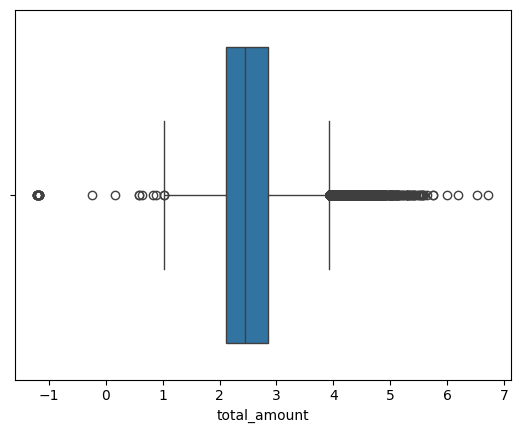

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df["total_amount"])
plt.show()

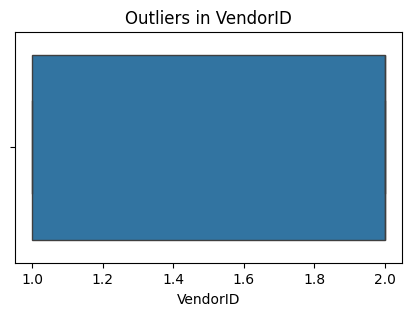

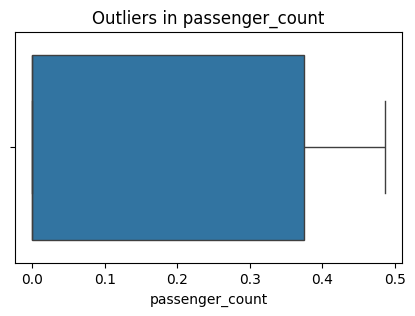

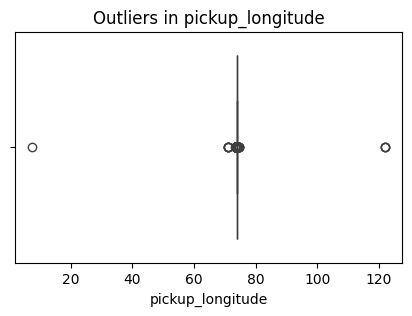

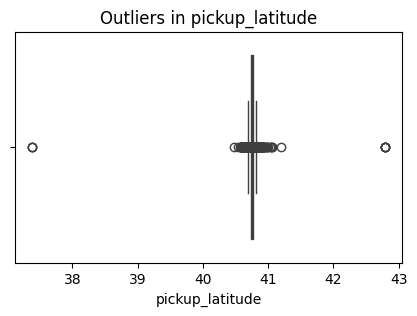

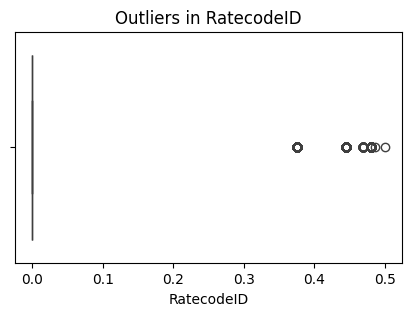

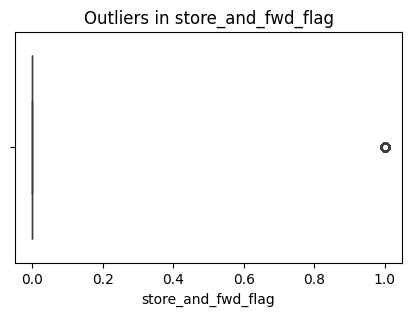

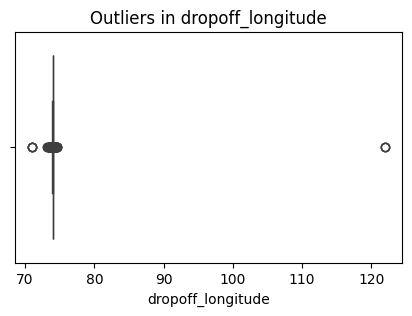

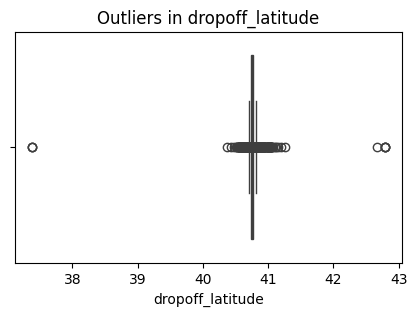

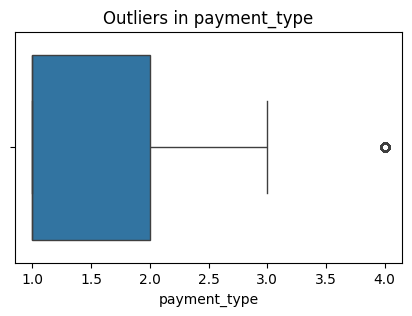

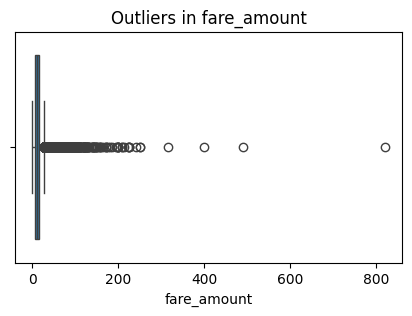

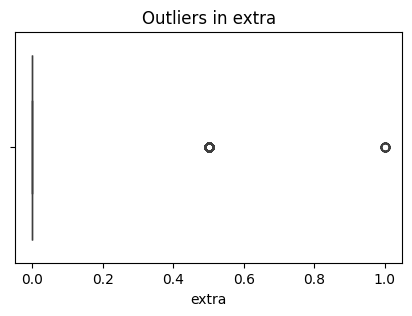

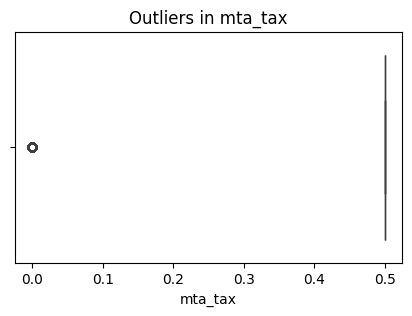

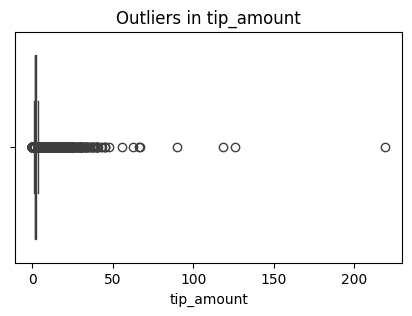

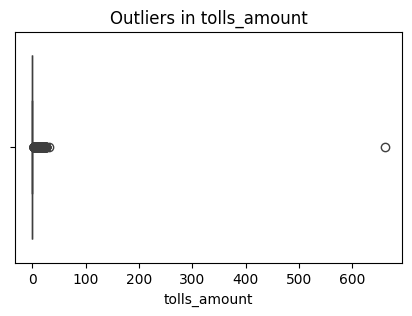

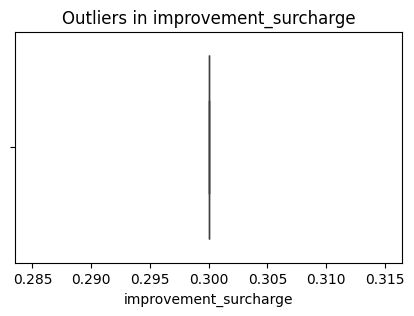

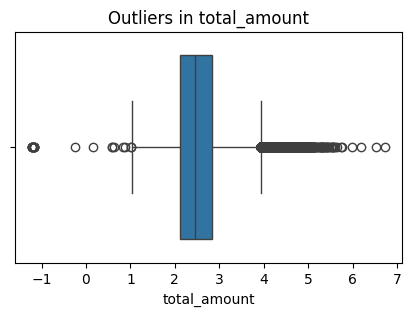

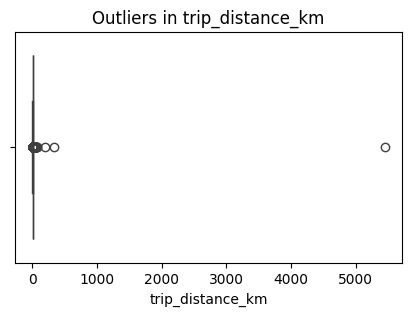

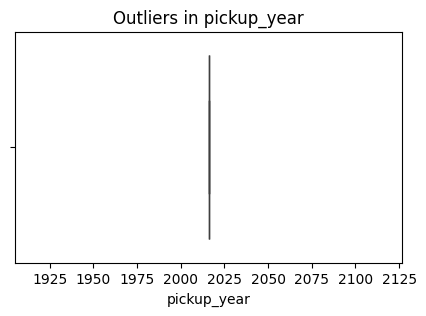

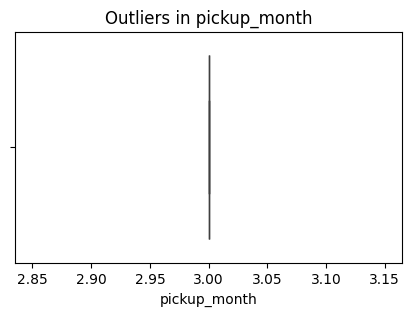

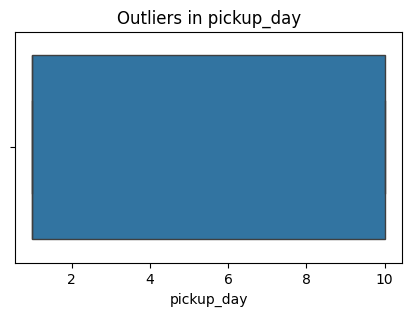

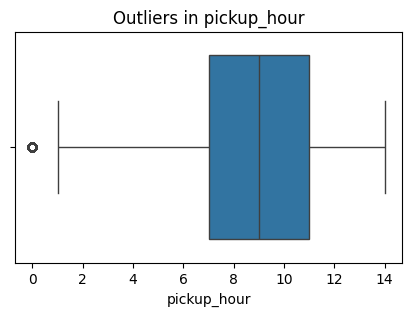

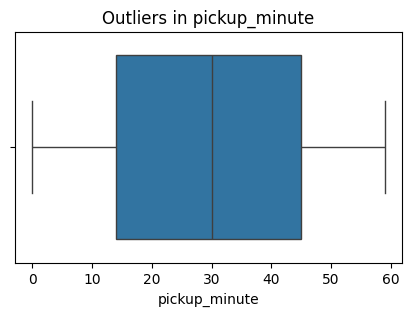

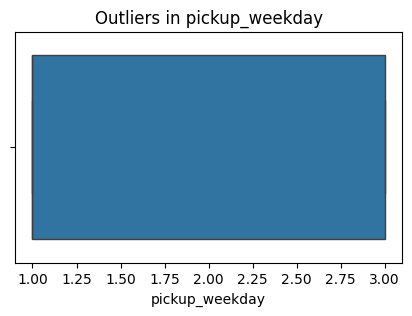

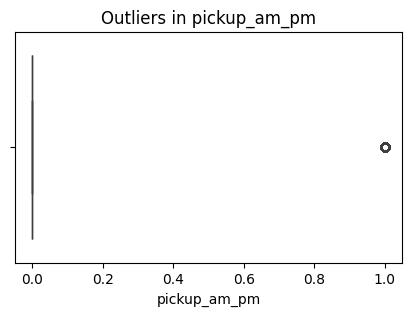

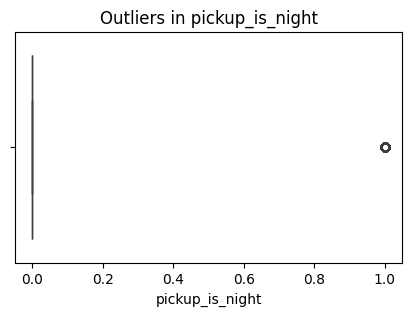

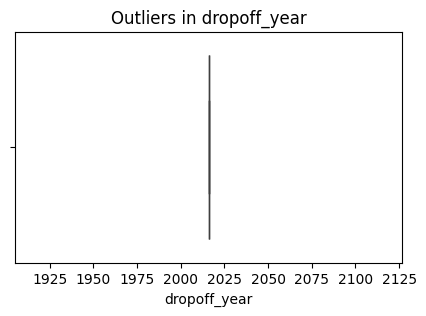

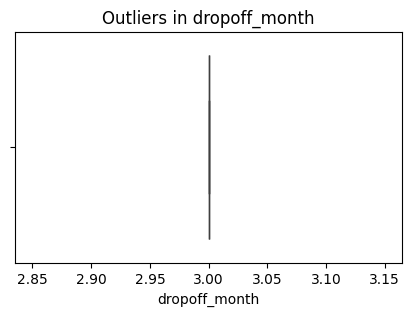

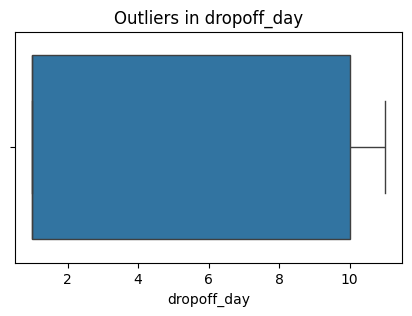

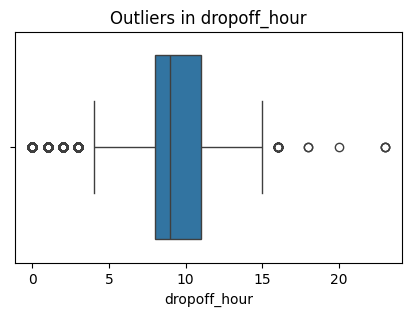

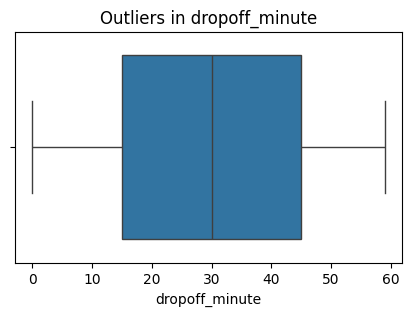

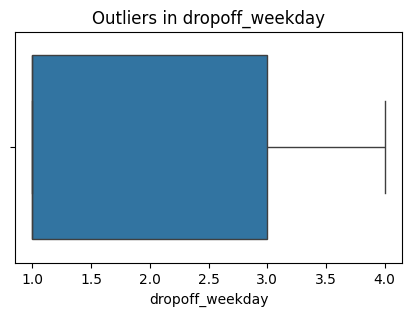

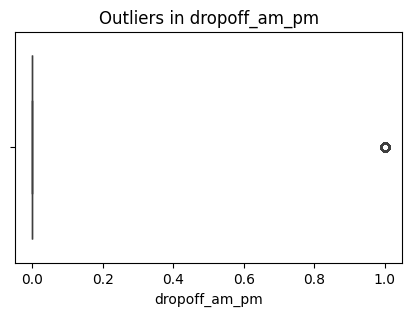

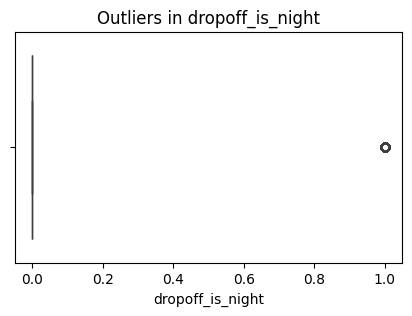

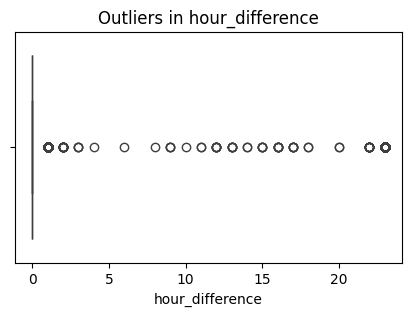

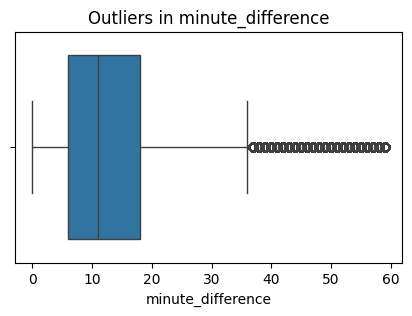

In [178]:
# --------------------------
# 4. Outliers Detection (Numeric Columns)
# --------------------------
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=df[col])
    plt.title(f"Outliers in {col}")
    plt.show()

# ** Preprocessing**

In [179]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'trip_distance_km', 'pickup_year', 'pickup_month', 'pickup_day',
       'pickup_hour', 'pickup_minute', 'pickup_weekday', 'pickup_am_pm',
       'pickup_is_night', 'dropoff_year', 'dropoff_month', 'dropoff_day',
       'dropoff_hour', 'dropoff_minute', 'dropoff_weekday', 'dropoff_am_pm',
       'dropoff_is_night', 'hour_difference', 'minute_difference'],
      dtype='object')

In [180]:
df.drop(columns=["pickup_year","pickup_month","pickup_day","pickup_hour","pickup_minute",'dropoff_year',
       'dropoff_month', 'dropoff_day', 'dropoff_hour', 'dropoff_minute'],inplace=True)

In [181]:
df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'],inplace=True)

**Feature Engineering**

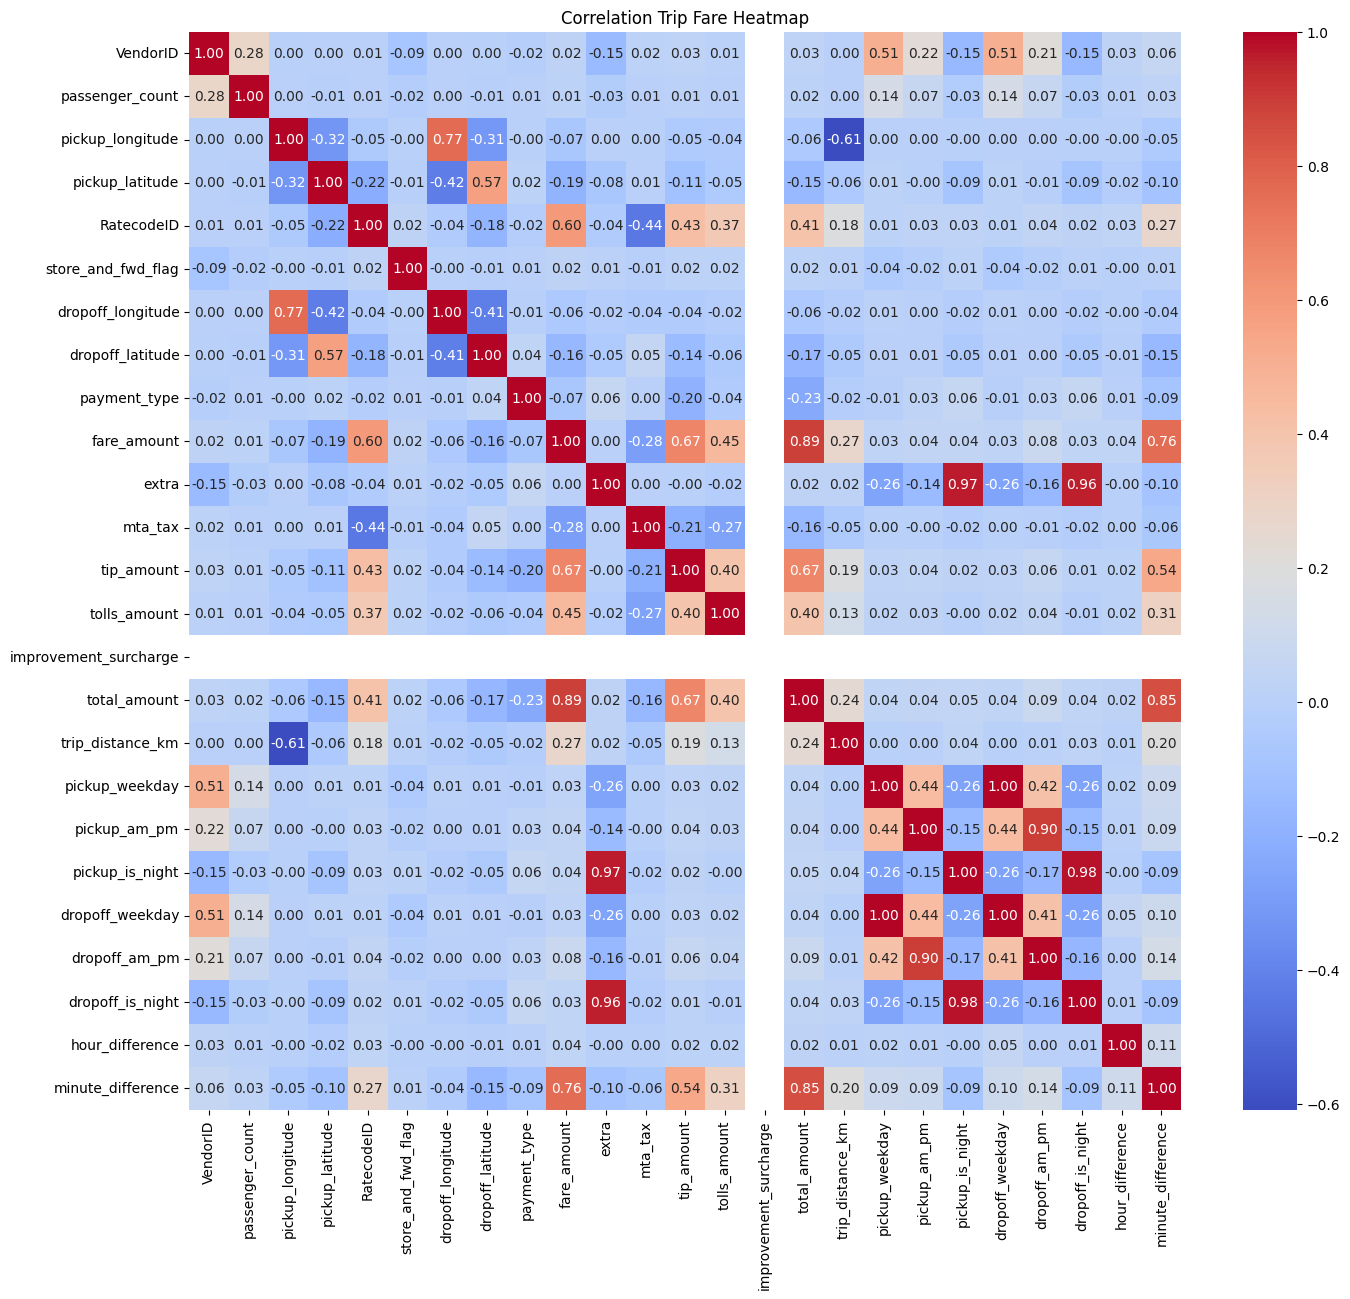

In [182]:

df_copy = df.copy()


# -----------------------------------------------------------------------------
#                               Correlation Test
# ---------------------------------------------------------------------------

import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------------------
# Calculate correlation for Trip Fare
# ----------------------------------------
corr = df_copy.corr()

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Trip Fare Heatmap")
plt.show()



# **Hypothesis testing**

In [183]:
df.columns

Index(['VendorID', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'RatecodeID', 'store_and_fwd_flag', 'dropoff_longitude',
       'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'trip_distance_km', 'pickup_weekday', 'pickup_am_pm', 'pickup_is_night',
       'dropoff_weekday', 'dropoff_am_pm', 'dropoff_is_night',
       'hour_difference', 'minute_difference'],
      dtype='object')

In [184]:
continuous = [
    'passenger_count',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'fare_amount',
    'extra',
    'mta_tax',
    'tip_amount',
    'tolls_amount',
    'total_amount',
    'trip_distance_km',
    'hour_difference',
    'minute_difference',
    'improvement_surcharge'
]

category = [
    'VendorID',               # Categorical: Vendor IDs (1, 2)
    'RatecodeID',             # Categorical: Rate codes
    'store_and_fwd_flag',     # Yes/No flag
    'payment_type',           # Categorical: Credit card, cash, etc.
    'pickup_weekday',         # 0–6 (Monday–Sunday)
    'pickup_am_pm',           # AM or PM
    'pickup_is_night',        # Yes/No
    'dropoff_weekday',        # 0–6
    'dropoff_am_pm',          # AM or PM
    'dropoff_is_night'        # Yes/No
]


# **Data Transformation**

In [185]:

from scipy import stats

#continious vs continious
def two_sample(d1,d2):
  t=0
  f=0
  for i in  range(31):
    sample1=d1.sample(frac=0.03)
    sample2=d2.sample(frac=0.03)
    t_test,p_value=stats.ttest_ind(sample1,sample2)
    if p_value < 0.1:
      f=f+1
    else:
      t=t+1
  if t>f:
    return True
  else:
    return False


In [186]:
#cat vs cat
def chisquare_cat_vs_cat(d1,d2):
    return True if stats.chi2_contingency(pd.crosstab(d1,d2))[1] < 0.1 else False

In [187]:
#continious(d1) vs cat(d2)
def annova_test(d1,d2):
    group= df[d2].unique()
    data = {}
    for i in group:
        # Check if the category has more than one data point
        if len(df[d1][df[d2]==i]) > 1:
            data[i]=df[d1][df[d2]==i]
    # Check if there are at least two groups with more than one data point
    if len(data) < 2:
        return False  # Cannot perform ANOVA with less than two groups
    f_value,p_value=stats.f_oneway(*[i for i in data.values()])
    return False if p_value < 0.1 else True


In [188]:
final = {}
for i in df.columns:
    final[i]={}
    for j in df.columns:
        if (i in continuous) and (j in continuous):
            result=two_sample(df[i],df[j])
        elif (i in continuous) and (j in category):
            result=annova_test(i,j)
        elif (i in category) and (j in continuous):
            result=annova_test(j,i)
        elif (i in category) and (j in category):
            result=chisquare_cat_vs_cat(df[i],df[j])
        if result:
            final[i][j]=1
        else:
            final[i][j]=0

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:579: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:579: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:579: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/

In [189]:
final_df = pd.DataFrame(final)
final_df

,VendorID,passenger_count,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,...,total_amount,trip_distance_km,pickup_weekday,pickup_am_pm,pickup_is_night,dropoff_weekday,dropoff_am_pm,dropoff_is_night,hour_difference,minute_difference
VendorID,1,0,1,0,1,1,0,1,1,0,...,0,1,1,1,1,1,1,1,0,0
passenger_count,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pickup_longitude,1,0,1,0,0,1,1,0,1,0,...,0,0,1,0,1,1,1,1,0,0
pickup_latitude,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
RatecodeID,1,0,0,0,1,1,0,0,1,0,...,0,0,1,1,1,1,1,1,0,0
store_and_fwd_flag,1,0,1,0,1,1,1,0,1,0,...,0,0,1,1,1,1,1,1,1,0
dropoff_longitude,0,0,1,0,0,1,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
dropoff_latitude,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
payment_type,1,0,1,0,1,1,0,0,1,0,...,0,0,1,1,1,1,1,1,0,0
fare_amount,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

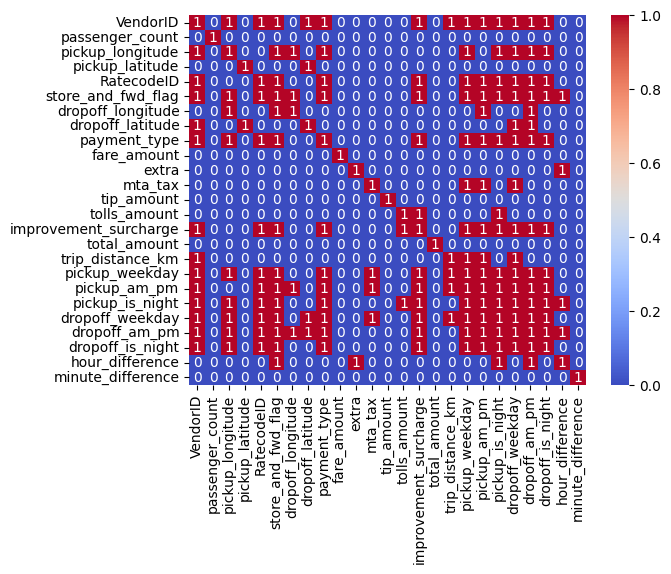

In [190]:
import seaborn as sns
sns.heatmap(final_df,annot=True,cmap="coolwarm")

# **Train the model ML**

In [191]:
df.columns

Index(['VendorID', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'RatecodeID', 'store_and_fwd_flag', 'dropoff_longitude',
       'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'trip_distance_km', 'pickup_weekday', 'pickup_am_pm', 'pickup_is_night',
       'dropoff_weekday', 'dropoff_am_pm', 'dropoff_is_night',
       'hour_difference', 'minute_difference'],
      dtype='object')

In [192]:
df

,VendorID,passenger_count,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,...,total_amount,trip_distance_km,pickup_weekday,pickup_am_pm,pickup_is_night,dropoff_weekday,dropoff_am_pm,dropoff_is_night,hour_difference,minute_difference
0,1,0.000000,73.976746,40.765152,0.000000,0,74.004265,40.746128,1,9.0,...,2.513656,3.138096,1,0,1,1,0,1,0.0,7.0
1,1,0.000000,73.983482,40.767925,0.000000,0,74.005943,40.733166,1,11.0,...,2.731115,4.303331,1,0,1,1,0,1,0.0,11.0
2,2,0.375000,73.782021,40.644810,0.000000,0,73.974541,40.675770,1,54.5,...,4.155753,16.600142,1,0,1,1,0,1,0.0,31.0
3,2,0.444444,73.863419,40.769814,0.000000,0,73.969650,40.757767,1,31.5,...,3.728581,9.046547,1,0,1,1,0,1,0.0,0.0
4,2,0.480000,73.971741,40.792183,0.444444,0,74.177170,40.695053,1,98.0,...,4.734443,20.400022,1,0,1,1,0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212340,2,0.000000,73.955688,40.782261,0.000000,0,73.974915,40.751282,1,16.0,...,3.003700,3.806279,1,1,0,1,1,0,0.0,23.0
212341,2,0.000000,74.002197,40.715042,0.000000,0,73.976295,40.739609,1,15.5,...,2.906901,3.496576,1,1,0,1,1,0,0.0,22.0
212342,2,0.000000,73.991173,40.733170,0.000000,0,73.994324,40.728531,1,4.0,...,1.568616,0.580119,1,1,0,1,1,0,0.0,2.0
212343,1,0.375000,73.972099,40.786446,0.000000,0,73.955872,40.779755,2,7.0,...,2.054124,1.555737,1,1,0,1,1,0,0.0,7.0


In [193]:
y = df['fare_amount']
x = df.drop('fare_amount',axis=1)

In [194]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((167690, 24), (41923, 24), (167690,), (41923,))

In [195]:
# Step 1
# Check for infinite values in x_train
print(x_train.columns[np.isinf(x_train).any()])

Index([], dtype='object')


In [ ]:
# Step 2 for replacing inf values ,replaced the values by mean()
x_train.replace([np.inf,-np.inf],np.nan,inplace=True)
x_test.replace([np.inf,-np.inf],np.nan,inplace=True)
x_train.fillna(x_train.mean(),inplace=True)
x_test.fillna(x_test.mean(),inplace=True)

In [ ]:
# Step 3
# Check for infinite values in x_train
print(x_train.columns[np.isinf(x_train).any()])

In [196]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score

model = RandomForestRegressor().fit(x_train,y_train)
y_pred = model.predict(x_test)
print(mean_absolute_error(y_test,y_pred))
print(mean_absolute_percentage_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

0.03892827593574566
0.07287408252653817
1.1355979843326325
0.9898435225635535


In [ ]:
# Model 1
from sklearn.svm import SVR
model1 = SVR().fit(x_train,y_train)
y_pred = model1.predict(x_test)
print(mean_absolute_error(y_test,y_pred))
print(mean_absolute_percentage_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

In [197]:
# Model 2
from sklearn.neighbors import KNeighborsRegressor
model2 = KNeighborsRegressor(n_neighbors=3)
model2.fit(x_train,y_train)
y_pred = model2.predict(x_test)
print(mean_absolute_error(y_test,y_pred))
print(mean_absolute_percentage_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

0.6225914503411163
0.2519117331743747
10.675102476198399
0.9045248063776894


In [198]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

# Predictions
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Function to print metrics
def print_metrics(y_true, y_pred, dataset_name):
    print(f"\n📊 {dataset_name} Metrics")
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("MAPE:", mean_absolute_percentage_error(y_true, y_pred))
    print("MSE :", mean_squared_error(y_true, y_pred))
    print("R²  :", r2_score(y_true, y_pred))

# Training metrics
print_metrics(y_train, y_train_pred, "Training")

# Test metrics
print_metrics(y_test, y_test_pred, "Test")


📊 Training Metrics
MAE : 0.01574562051538764
MAPE: 0.008056095184797845
MSE : 0.56748776587915
R²  : 0.9951160659392082

📊 Test Metrics
MAE : 0.03892827593574566
MAPE: 0.07287408252653817
MSE : 1.1355979843326325
R²  : 0.9898435225635535


In [199]:
df.columns

Index(['VendorID', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'RatecodeID', 'store_and_fwd_flag', 'dropoff_longitude',
       'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'trip_distance_km', 'pickup_weekday', 'pickup_am_pm', 'pickup_is_night',
       'dropoff_weekday', 'dropoff_am_pm', 'dropoff_is_night',
       'hour_difference', 'minute_difference'],
      dtype='object')

In [201]:
import pandas as pd

# Input data WITHOUT 'fare_amount' since it's the target
input_data = {
    'VendorID': 1,
    'passenger_count': 2,
    'pickup_longitude': -73.985428,
    'pickup_latitude': 40.748817,
    'RatecodeID': 1,
    'store_and_fwd_flag': 1,
    'dropoff_longitude': -73.985428,
    'dropoff_latitude': 40.748817,
    'payment_type': 1,
    'extra': 0.5,
    'mta_tax': 0.5,
    'tip_amount': 1.0,
    'tolls_amount': 0.0,
    'improvement_surcharge': 0.3,
    'total_amount': 12.8,
    'trip_distance_km': 1.2,
    'pickup_weekday': 4,
    'pickup_am_pm': 0,
    'pickup_is_night': 0,
    'dropoff_weekday': 4,
    'dropoff_am_pm': 0,
    'dropoff_is_night': 0,
    'hour_difference': 0,
    'minute_difference': 15
}

input_df = pd.DataFrame([input_data])

# Predict fare_amount
predicted_fare = model.predict(input_df)

print(f"Predicted fare_amount: {predicted_fare[0]}")


Predicted fare_amount: 385.5008


In [203]:
input_data = {
    'VendorID': 1,
    'passenger_count': 2,
    'pickup_longitude': -73.985428,
    'pickup_latitude': 40.748817,
    'RatecodeID': 1,
    'store_and_fwd_flag': 0,        # 'N' -> 0, 'Y' -> 1
    'dropoff_longitude': -73.985428,
    'dropoff_latitude': 40.748817,
    'payment_type': 1,
    'extra': 0.5,
    'mta_tax': 0.5,
    'tip_amount': 1.0,
    'tolls_amount': 0.0,
    'improvement_surcharge': 0.3,
    'total_amount': 12.8,
    'trip_distance_km': 1.2,
    'pickup_weekday': 4,
    'pickup_am_pm': 1,              # 'AM' -> 0, 'PM' -> 1
    'pickup_is_night': 0,           # 'No' -> 0, 'Yes' -> 1
    'dropoff_weekday': 4,
    'dropoff_am_pm': 1,             # 'AM' -> 0, 'PM' -> 1
    'dropoff_is_night': 0,          # 'No' -> 0, 'Yes' -> 1
    'hour_difference': 0,
    'minute_difference': 15
}
input_df = pd.DataFrame([input_data])

# Predict fare_amount
predicted_fare = model.predict(input_df)

print(f"Predicted fare_amount: {predicted_fare[0]}")


Predicted fare_amount: 382.80080000000004


In [205]:
inputs = [
    {
        'VendorID': 1,
        'passenger_count': 1,
        'pickup_longitude': -73.9780,
        'pickup_latitude': 40.7527,
        'RatecodeID': 1,
        'store_and_fwd_flag': 0,       # 'N'
        'dropoff_longitude': -73.9815,
        'dropoff_latitude': 40.7550,
        'payment_type': 1,
        'extra': 0.5,
        'mta_tax': 0.5,
        'tip_amount': 0.0,
        'tolls_amount': 0.0,
        'improvement_surcharge': 0.3,
        'total_amount': 9.0,
        'trip_distance_km': 0.4,
        'pickup_weekday': 2,
        'pickup_am_pm': 0,              # 'AM'
        'pickup_is_night': 0,           # 'No'
        'dropoff_weekday': 2,
        'dropoff_am_pm': 0,             # 'AM'
        'dropoff_is_night': 0,          # 'No'
        'hour_difference': 0,
        'minute_difference': 7
    },
    {
        'VendorID': 2,
        'passenger_count': 3,
        'pickup_longitude': -73.9900,
        'pickup_latitude': 40.7500,
        'RatecodeID': 2,
        'store_and_fwd_flag': 1,       # 'Y'
        'dropoff_longitude': -74.0100,
        'dropoff_latitude': 40.7300,
        'payment_type': 2,
        'extra': 1.0,
        'mta_tax': 0.5,
        'tip_amount': 2.5,
        'tolls_amount': 3.0,
        'improvement_surcharge': 0.3,
        'total_amount': 32.8,
        'trip_distance_km': 7.8,
        'pickup_weekday': 5,
        'pickup_am_pm': 1,              # 'PM'
        'pickup_is_night': 1,           # 'Yes'
        'dropoff_weekday': 5,
        'dropoff_am_pm': 1,             # 'PM'
        'dropoff_is_night': 1,          # 'Yes'
        'hour_difference': 0,
        'minute_difference': 20
    },
    {
        'VendorID': 1,
        'passenger_count': 2,
        'pickup_longitude': -73.9950,
        'pickup_latitude': 40.7550,
        'RatecodeID': 1,
        'store_and_fwd_flag': 0,       # 'N'
        'dropoff_longitude': -73.9850,
        'dropoff_latitude': 40.7450,
        'payment_type': 1,
        'extra': 0.5,
        'mta_tax': 0.5,
        'tip_amount': 1.5,
        'tolls_amount': 0.0,
        'improvement_surcharge': 0.3,
        'total_amount': 17.3,
        'trip_distance_km': 3.2,
        'pickup_weekday': 3,
        'pickup_am_pm': 1,              # 'PM'
        'pickup_is_night': 0,           # 'No'
        'dropoff_weekday': 3,
        'dropoff_am_pm': 1,             # 'PM'
        'dropoff_is_night': 0,          # 'No'
        'hour_difference': 0,
        'minute_difference': 12
    }
]

# Convert to DataFrame and predict
import pandas as pd

input_df = pd.DataFrame(inputs)
predicted_fares = model.predict(input_df)

for i, fare in enumerate(predicted_fares):
    print(f"Input {i+1} predicted fare_amount: {fare}")


Input 1 predicted fare_amount: 396.1729
Input 2 predicted fare_amount: 381.67370000000005
Input 3 predicted fare_amount: 379.5108


In [206]:
input_data = {
    'VendorID': 1,
    'passenger_count': 2,
    'pickup_longitude': -73.96985626,
    'pickup_latitude': 40.75365829,
    'RatecodeID': 1,
    'store_and_fwd_flag': 0,       # 'N' → 0
    'dropoff_longitude': -73.80845642,
    'dropoff_latitude': 41.03174973,
    'payment_type': 1,
    # 'fare_amount': 69,           # This is target, so omit for prediction
    'extra': 0,
    'mta_tax': 0.5,
    'tip_amount': 34,
    'tolls_amount': 5.54,
    'improvement_surcharge': 0.3,
    'total_amount': 109.34,
    'trip_distance_km': 33.76752431,
    'pickup_weekday': 3,           # From date 3/10/2016
    'pickup_am_pm': 0,             # 'AM' → 0
    'pickup_is_night': 0,          # 'No' → 0
    'dropoff_weekday': 3,
    'dropoff_am_pm': 0,            # 'AM' → 0
    'dropoff_is_night': 0,
    'hour_difference': 0,          # 8:57 - 8:10 = 0 hours? No, calculate next
    'minute_difference': 47       # 47 minutes difference
}

# Correct hour_difference calculation:
pickup_hour = 8
dropoff_hour = 8
hour_difference = dropoff_hour - pickup_hour  # 0
minute_difference = 47  # from 10 to 57

input_data['hour_difference'] = hour_difference
input_data['minute_difference'] = minute_difference
input_data['pickup_am_pm'] = 0  # AM
input_data['dropoff_am_pm'] = 0  # AM

# Now convert to DataFrame and predict:

import pandas as pd
input_df = pd.DataFrame([input_data])

predicted_fare = model.predict(input_df)
print(f"Predicted fare_amount: {predicted_fare[0]}")


Predicted fare_amount: 368.1016
